# Multi-Scale Model

## Package

In [2]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 8 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 1s (112 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 110377 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2_amd64.deb ...
Unpacking libopenslide0 (3.4.1+dfsg-2) ...
Selecting previously unselected package openslide-tools.
Preparing to unpack .

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
import pathlib
from PIL import Image
from skimage.color import rgb2gray
import cv2
import random
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
from sklearn.metrics import *
import pandas as pd

tf.enable_eager_execution()

In [4]:
# Download an example slide and tumor mask
# Note: these are hosted on Google Cloud Storage.
# The remainder are in a Google Drive folder, linked above.

slide_path_091 = 'tumor_091.tif'
tumor_mask_path_091 = 'tumor_091_mask.tif'

slide_url_091 = 'https://storage.googleapis.com/applied-dl/%s' % slide_path_091
mask_url_091 = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path_091

# Download the whole slide image
if not os.path.exists(slide_path_091):
  !curl -O $slide_url_091

# Download the tumor mask
if not os.path.exists(tumor_mask_path_091):
  !curl -O $mask_url_091
  
slide_091 = open_slide(slide_path_091)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path_091, 
                                                        slide_091.level_dimensions[0][0], 
                                                        slide_091.level_dimensions[0][1]))

tumor_mask_091 = open_slide(tumor_mask_path_091)
print ("Read tumor mask from %s" % (tumor_mask_path_091))

print("Slide includes %d levels" % len(slide_091.level_dimensions))
for i in range(len(slide_091.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide_091.level_dimensions[i], 
                                                             slide_091.level_downsamples[i]))
    assert tumor_mask_091.level_dimensions[i][0] == slide_091.level_dimensions[i][0]
    assert tumor_mask_091.level_dimensions[i][1] == slide_091.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide_091.level_dimensions[7]
assert width * slide_091.level_downsamples[7] == slide_091.level_dimensions[0][0]
assert height * slide_091.level_downsamples[7] == slide_091.level_dimensions[0][1]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  521M  100  521M    0     0   126M      0  0:00:04  0:00:04 --:--:--  126M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14.6M  100 14.6M    0     0  39.7M      0 --:--:-- --:--:-- --:--:-- 39.7M
Read WSI from tumor_091.tif with width: 61440, height: 53760
Read tumor mask from tumor_091_mask.tif
Slide includes 8 levels
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensi

## Function

In [0]:
def create_folder_train(slide_path, level):
    BASE_DIR = os.getcwd()
    img_num = slide_path.split('_')[1].strip(".tif")
    DATA = 'data/'
    IMG_NUM_FOLDER = img_num + '/'
    LEVEL_FOLDER = 'level_'+str(level)+'/'
    TUMOR_FOLDER = 'tumor/'
    NO_TUMOR_FOLDER = 'no_tumor/'

    DATA_DIR = os.path.join(BASE_DIR, DATA)
    IMG_NUM_DIR = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER)
    LEVEL_NUM_DIR = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER, LEVEL_FOLDER)
    TUMOR_DIR = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER, LEVEL_FOLDER, TUMOR_FOLDER)
    NO_TUMOR_DIR = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER, LEVEL_FOLDER, NO_TUMOR_FOLDER)

    if not os.path.exists(DATA_DIR):
        os.mkdir(DATA_DIR)
    if not os.path.exists(IMG_NUM_DIR):
        os.mkdir(IMG_NUM_DIR)
    if not os.path.exists(LEVEL_NUM_DIR):
        os.mkdir(LEVEL_NUM_DIR)
    if not os.path.exists(TUMOR_DIR):
        os.mkdir(TUMOR_DIR)
    if not os.path.exists(NO_TUMOR_DIR):
        os.mkdir(NO_TUMOR_DIR)

    return DATA + IMG_NUM_FOLDER + LEVEL_FOLDER + TUMOR_FOLDER, DATA + IMG_NUM_FOLDER + LEVEL_FOLDER + NO_TUMOR_FOLDER

def create_folder_test(slide_path, level):
    BASE_DIR = os.getcwd()
    img_num = slide_path.split('_')[1].strip(".tif")
    DATA = 'data/'
    IMG_NUM_FOLDER = img_num + '/'
    LEVEL_FOLDER = 'level_'+str(level)+'/'
    TISSUE_FOLDER = 'tissue_only/'
    ALL_FOLDER = 'all/'

    DATA_DIR = os.path.join(BASE_DIR, DATA)
    IMG_NUM_DIR = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER)
    LEVEL_NUM_DIR = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER, LEVEL_FOLDER)
    TISSUE_DIR = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER, LEVEL_FOLDER, TISSUE_FOLDER)
    ALL_DIR = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER, LEVEL_FOLDER, ALL_FOLDER)

    if not os.path.exists(DATA_DIR):
        os.mkdir(DATA_DIR)
    if not os.path.exists(IMG_NUM_DIR):
        os.mkdir(IMG_NUM_DIR)
    if not os.path.exists(LEVEL_NUM_DIR):
        os.mkdir(LEVEL_NUM_DIR)
    if not os.path.exists(TISSUE_DIR):
        os.mkdir(TISSUE_DIR)
    if not os.path.exists(ALL_DIR):
        os.mkdir(ALL_DIR)

    return DATA + IMG_NUM_FOLDER + LEVEL_FOLDER + TISSUE_FOLDER, DATA + IMG_NUM_FOLDER + LEVEL_FOLDER + ALL_FOLDER

def load_image(slide_path, tumor_mask_path):

    if not os.path.exists(slide_path):
        os.system('gsutil cp gs://terry-columbia/deep_learning_final_project/' + slide_path + ' ' + slide_path)
    if not  os.path.exists(tumor_mask_path):
        os.system('gsutil cp gs://terry-columbia/deep_learning_final_project/' + tumor_mask_path + ' ' + tumor_mask_path)
    slide = open_slide(slide_path)
    tumor_mask = open_slide(tumor_mask_path)
    for i in range(len(slide.level_dimensions)-1):
        assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
        assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

    width, height = slide.level_dimensions[7]
    assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
    assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]
    return slide, tumor_mask

def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])

def apply_mask(im, mask, color = 1):
    masked = np.zeros((im.shape[0], im.shape[1]))
    for x,y in mask: masked[x][y] = color
    return masked

def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize_images(image, [128, 128])
    image /= 255.0  # normalize to [0,1] range
    return image

def load_preprocessed_image(path):
    image = tf.read_file(path)
    return preprocess_image(image)

def save_training_data(im, tumor_mask, tissue_mask,  num_pixels, level, slide_path):
    x, y = im.shape[0], im.shape[1]
    x_count, y_count = int(np.ceil(x / num_pixels)), int(np.ceil(y/num_pixels))
    tumor_folder, no_tumor_folder = create_folder_train(slide_path, level)
    try:
        for i in range(x_count):
            for j in range(y_count):
                im_slice = np.zeros((num_pixels, num_pixels, 3))
                tissue_mask_slice = np.zeros((num_pixels, num_pixels))
                tumor_mask_slice = np.zeros((num_pixels, num_pixels))
                string_name = 'img_' + str(i * y_count + j)
                
                if i == x_count-1:
                    ub_x = x
                    assign_x = x - (x_count-1)*num_pixels
                else:
                    ub_x = (i+1) * num_pixels
                    assign_x = num_pixels
                if j == y_count-1:
                    ub_y = y
                    assign_y = y - (y_count-1)*num_pixels
                else:
                    ub_y = (j+1) * num_pixels
                    assign_y = num_pixels
                    
                tissue_mask_slice[0:assign_x, 0:assign_y] = tissue_mask[(i*num_pixels) :ub_x, (j * num_pixels) :ub_y]
                try:
                    if np.mean(tissue_mask_slice) > 0.7:
                        im_slice[0:assign_x, 0:assign_y, :] = im[(i*num_pixels) :ub_x, (j * num_pixels) :ub_y, :]
                        tumor_mask_slice[0:assign_x, 0:assign_y] = tumor_mask[(i*num_pixels) :ub_x, (j * num_pixels) :ub_y]

                        if np.max(tumor_mask_slice) > 0:
                            im_file_name = tumor_folder + string_name + ".jpg"
                        else:
                            im_file_name = no_tumor_folder + string_name + ".jpg"

                        cv2.imwrite(im_file_name, im_slice)
                except Exception as oerr:
                    print('Error with saving:', oerr)
    except Exception as oerr:
        print('Error with slicing:', oerr)
        
def save_test_data(im, tissue_mask, num_pixels, level_num, slide_path):
    x, y = im.shape[0], im.shape[1]
    x_count, y_count = int(np.ceil(x / num_pixels)), int(np.ceil(y / num_pixels))
    tissue_folder, all_folder = create_folder_test(slide_path, level_num)
    try:
        for i in range(x_count):
            for j in range(y_count):
                im_slice = np.zeros((num_pixels, num_pixels, 3))
                im_tissue_slice = np.zeros((num_pixels, num_pixels, 3))
                tissue_mask_slice = np.zeros((num_pixels, num_pixels))
                string_name = 'img_' + str(i * y_count + j)

                if i == x_count - 1:
                    ub_x = x
                    assign_x = x - (x_count - 1) * num_pixels
                else:
                    ub_x = (i + 1) * num_pixels
                    assign_x = num_pixels
                if j == y_count - 1:
                    ub_y = y
                    assign_y = y - (y_count - 1) * num_pixels
                else:
                    ub_y = (j + 1) * num_pixels
                    assign_y = num_pixels

                tissue_mask_slice[0:assign_x, 0:assign_y] = tissue_mask[(i * num_pixels):ub_x, (j * num_pixels):ub_y]
                try:
                    if np.mean(tissue_mask_slice) > 0.7:
                        im_tissue_slice[0:assign_x, 0:assign_y, :] = im[(i * num_pixels):ub_x, (j * num_pixels):ub_y, :]
                        im_file_name_tissue = tissue_folder + string_name + ".jpg"
                        cv2.imwrite(im_file_name_tissue, im_tissue_slice)
                        
                    im_slice[0:assign_x, 0:assign_y, :] = im[(i * num_pixels):ub_x, (j * num_pixels):ub_y, :]
                    im_file_name_all = all_folder + string_name + ".jpg"
                    cv2.imwrite(im_file_name_all, im_slice)
                except Exception as oerr:
                    print('Error with saving:', oerr)
    except Exception as oerr:
        print('Error with slicing:', oerr)

def create_second_level(slide_path, input_level, num_input_pixels, output_level, num_output_pixels):
    img_num = slide_path.split('_')[1].strip(".tif")
    BASE_DIR = os.getcwd()
    DATA = 'data/'
    LEVEL_INPUT_FOLDER = 'level_' + str(input_level) + '/'
    LEVEL_OUTPUT_FOLDER = 'level_' + str(output_level) + '/'
    TISSUE_FOLDER = 'tissue_only/'
    ALL_FOLDER = 'all/'

    TISSUE_DIR_INPUT   = os.path.join(BASE_DIR, DATA, img_num, LEVEL_INPUT_FOLDER, TISSUE_FOLDER)
    ALL_DIR_INPUT      = os.path.join(BASE_DIR, DATA, img_num, LEVEL_INPUT_FOLDER, ALL_FOLDER)
    LEVEL_DIR_OUTPUT   = os.path.join(BASE_DIR, DATA, img_num, LEVEL_OUTPUT_FOLDER)
    TISSUE_DIR_OUTPUT  = os.path.join(BASE_DIR, DATA, img_num, LEVEL_OUTPUT_FOLDER, TISSUE_FOLDER)
    ALL_DIR_OUTPUT     = os.path.join(BASE_DIR, DATA, img_num, LEVEL_OUTPUT_FOLDER, ALL_FOLDER)

    if not os.path.exists(LEVEL_DIR_OUTPUT):
        os.mkdir(LEVEL_DIR_OUTPUT)
    if not os.path.exists(TISSUE_DIR_OUTPUT):
        os.mkdir(TISSUE_DIR_OUTPUT)
    if not os.path.exists(ALL_DIR_OUTPUT):
        os.mkdir(ALL_DIR_OUTPUT)

    data_root_tissue_input = pathlib.Path(TISSUE_DIR_INPUT)
    all_image_paths_tissue_input = list(data_root_tissue_input.glob('*'))
    all_paths_tissue_str_input   = [str(path) for path in all_image_paths_tissue_input]
    num_tissue_images_input = len(all_image_paths_tissue_input)
    
    data_root_all_input = pathlib.Path(ALL_DIR_INPUT)
    all_image_paths_all_input = list(data_root_all_input.glob('*'))
    all_paths_all_str_input   = [str(path) for path in all_image_paths_all_input]
    num_all_images_input = len(all_paths_all_str_input)

    slide = open_slide(slide_path)
    input_width, input_height = slide.level_dimensions[input_level][0], slide.level_dimensions[input_level][1]
    output_width, output_height = slide.level_dimensions[output_level][0], slide.level_dimensions[output_level][1]
    slide = read_slide(slide,
                       x=0,
                       y=0,
                       level=output_level,
                       width=output_width,
                       height=output_height)

    row_count, col_count = int(np.ceil(input_height / num_input_pixels)), int(np.ceil(input_width / num_input_pixels))
    for i in all_paths_tissue_str_input + all_paths_all_str_input:
        try:
            img_index = i.split('_')[-1].strip(".jpg")
            start_input_row_count, start_input_col_count = (int(img_index) // col_count), (int(img_index) %  col_count)
            start_input_row_index = start_input_row_count * num_input_pixels 
            start_input_col_index = start_input_col_count * num_input_pixels

            scale_factor = 2 ** (output_level - input_level)
            shift_middle = (1 - 1/scale_factor)/2

            start_output_row = start_input_row_index * 1/scale_factor
            start_output_col = start_input_col_index * 1/scale_factor

            shift_pixels_up_left = shift_middle * num_output_pixels
            shift_pixels_down_right = (1 - shift_middle) * num_output_pixels

            temp_shift_row_top    = start_output_row - shift_pixels_up_left
            temp_shift_col_left   = start_output_col - shift_pixels_up_left
            temp_shift_row_bottom = start_output_row + shift_pixels_down_right
            temp_shift_col_right  = start_output_col + shift_pixels_down_right

            start_slice_top = 0
            start_slice_left = 0 
            end_slice_bottom = num_output_pixels
            end_slice_right  = num_output_pixels

            start_image_top    = int(np.max((temp_shift_row_top, 0)))
            start_image_left   = int(np.max((temp_shift_col_left, 0)))
            end_image_bottom   = int(np.min((temp_shift_row_bottom, output_height)))
            end_image_right    = int(np.min((temp_shift_col_right,  output_width)))

            if temp_shift_row_top < 0:
                start_slice_top = int(-temp_shift_row_top)
            if temp_shift_col_left < 0:
                start_slice_left = int(-temp_shift_col_left)
            if temp_shift_row_bottom > output_height:
                end_slice_bottom = int(num_output_pixels - (temp_shift_row_bottom - output_height))
            if temp_shift_col_right > output_width:
                end_slice_right  = int(num_output_pixels - (temp_shift_col_right - output_width))

            output_slice = np.zeros((num_output_pixels, num_output_pixels, 3))
            output_slice[start_slice_top: end_slice_bottom, start_slice_left: end_slice_right] = \
            slide[start_image_top: end_image_bottom, start_image_left: end_image_right]

            if i in all_paths_tissue_str_input:
                save_path = TISSUE_DIR_OUTPUT
            else:
                save_path = ALL_DIR_OUTPUT

            output_file_name = save_path + 'img_' + str(img_index) + '.jpg'
            try:
                cv2.imwrite(output_file_name, output_slice)
            except Exception as oerr:
                print('Error with saving:', oerr)
        except Exception as oerr:
            print('Error with slice:', oerr)

    data_root_tissue_output = pathlib.Path(TISSUE_DIR_OUTPUT)
    all_image_paths_tissue_output = list(data_root_tissue_output.glob('*'))
    all_paths_tissue_str_output   = [str(path) for path in all_image_paths_tissue_output]
    num_tissue_images_output = len(all_paths_tissue_str_output)

    data_root_all_output = pathlib.Path(ALL_DIR_OUTPUT)
    all_image_paths_all_output = list(data_root_all_output.glob('*'))
    all_paths_all_str_output   = [str(path) for path in all_image_paths_all_output]
    num_all_images_output = len(all_paths_all_str_output)

    if (num_tissue_images_output != num_tissue_images_input) or (num_all_images_output != num_all_images_input):
        print('ERROR: Number of output images not the same as number of input images')
        
def save_second_level(slide_path_list, input_level, num_input_pixels, output_level, num_output_pixels):        
    for slide_path in slide_path_list:
        img_num = slide_path.split('_')[1].strip(".tif")
        BASE_DIR = os.getcwd()
        DATA = 'data/'
        LEVEL_INPUT_FOLDER = 'level_' + str(input_level) + '/'
        LEVEL_OUTPUT_FOLDER = 'level_' + str(output_level) + '/'
        TUMOR_FOLDER = 'tumor/'
        NO_TUMOR_FOLDER = 'no_tumor/'

        TUMOR_DIR_INPUT    = os.path.join(BASE_DIR, DATA, img_num, LEVEL_INPUT_FOLDER, TUMOR_FOLDER)
        NO_TUMOR_DIR_INPUT = os.path.join(BASE_DIR, DATA, img_num, LEVEL_INPUT_FOLDER, NO_TUMOR_FOLDER)
        LEVEL_DIR_OUTPUT   = os.path.join(BASE_DIR, DATA, img_num, LEVEL_OUTPUT_FOLDER)
        TUMOR_DIR_OUTPUT   = os.path.join(BASE_DIR, DATA, img_num, LEVEL_OUTPUT_FOLDER, TUMOR_FOLDER)
        NO_TUMOR_DIR_OUTPUT = os.path.join(BASE_DIR, DATA, img_num, LEVEL_OUTPUT_FOLDER, NO_TUMOR_FOLDER)

        if not os.path.exists(LEVEL_DIR_OUTPUT):
            os.mkdir(LEVEL_DIR_OUTPUT)
        if not os.path.exists(TUMOR_DIR_OUTPUT):
            os.mkdir(TUMOR_DIR_OUTPUT)
        if not os.path.exists(NO_TUMOR_DIR_OUTPUT):
            os.mkdir(NO_TUMOR_DIR_OUTPUT)

        data_root_tumor_input = pathlib.Path(TUMOR_DIR_INPUT)
        all_image_paths_tumor_input = list(data_root_tumor_input.glob('*'))
        all_paths_tumor_str_input   = [str(path) for path in all_image_paths_tumor_input]
        num_tumor_images_input = len(all_image_paths_tumor_input)

        data_root_notumor_input = pathlib.Path(NO_TUMOR_DIR_INPUT)
        all_image_paths_notumor_input = list(data_root_notumor_input.glob('*'))
        all_paths_notumor_str_input   = [str(path) for path in all_image_paths_notumor_input]
        num_notumor_images_input = len(all_paths_notumor_str_input)

        slide = open_slide(slide_path)
        input_width, input_height = slide.level_dimensions[input_level][0], slide.level_dimensions[input_level][1]
        output_width, output_height = slide.level_dimensions[output_level][0], slide.level_dimensions[output_level][1]

        slide = read_slide(slide,
                           x=0,
                           y=0,
                           level=output_level,
                           width=output_width,
                           height=output_height)

        row_count, col_count = int(np.ceil(input_height / num_input_pixels)), int(np.ceil(input_width / num_input_pixels))
        for i in all_paths_tumor_str_input + all_paths_notumor_str_input:
            try:
                img_index = i.split('_')[-1].strip(".jpg")
                start_input_row_count, start_input_col_count = (int(img_index) // col_count), (int(img_index) %  col_count)
                start_input_row_index = start_input_row_count * num_input_pixels 
                start_input_col_index = start_input_col_count * num_input_pixels

                scale_factor = 2 ** (output_level - input_level)
                shift_middle = (1 - 1/scale_factor)/2

                start_output_row = start_input_row_index * 1/scale_factor
                start_output_col = start_input_col_index * 1/scale_factor

                shift_pixels_up_left = shift_middle * num_output_pixels
                shift_pixels_down_right = (1 - shift_middle) * num_output_pixels

                temp_shift_row_top    = start_output_row - shift_pixels_up_left
                temp_shift_col_left   = start_output_col - shift_pixels_up_left
                temp_shift_row_bottom = start_output_row + shift_pixels_down_right
                temp_shift_col_right  = start_output_col + shift_pixels_down_right

                start_slice_top = 0
                start_slice_left = 0 
                end_slice_bottom = num_output_pixels
                end_slice_right  = num_output_pixels

                start_image_top    = int(np.max((temp_shift_row_top, 0)))
                start_image_left   = int(np.max((temp_shift_col_left, 0)))
                end_image_bottom   = int(np.min((temp_shift_row_bottom, output_height)))
                end_image_right    = int(np.min((temp_shift_col_right,  output_width)))

                if temp_shift_row_top < 0:
                    start_slice_top = int(-temp_shift_row_top)
                if temp_shift_col_left < 0:
                    start_slice_left = int(-temp_shift_col_left)
                if temp_shift_row_bottom > output_height:
                    end_slice_bottom = int(num_output_pixels - (temp_shift_row_bottom - output_height))
                if temp_shift_col_right > output_width:
                    end_slice_right  = int(num_output_pixels - (temp_shift_col_right - output_width))

                output_slice = np.zeros((num_output_pixels, num_output_pixels, 3))
                output_slice[start_slice_top: end_slice_bottom, start_slice_left: end_slice_right] = \
                slide[start_image_top: end_image_bottom, start_image_left: end_image_right]

                if i in all_paths_tumor_str_input:
                    save_path = TUMOR_DIR_OUTPUT
                else:
                    save_path = NO_TUMOR_DIR_OUTPUT

                output_file_name = save_path + 'img_' + str(img_index) + '.jpg'
                try:
                    cv2.imwrite(output_file_name, output_slice)
                except Exception as oerr:
                    print('Error with saving:', oerr)
            except Exception as oerr:
                print('Error with slice:', oerr)

        data_root_tumor_output = pathlib.Path(TUMOR_DIR_OUTPUT)
        all_image_paths_tumor_output = list(data_root_tumor_output.glob('*'))
        all_paths_tumor_str_output   = [str(path) for path in all_image_paths_tumor_output]
        num_tumor_images_output = len(all_paths_tumor_str_output)

        data_root_notumor_output = pathlib.Path(NO_TUMOR_DIR_OUTPUT)
        all_image_paths_notumor_output = list(data_root_notumor_output.glob('*'))
        all_paths_notumor_str_output   = [str(path) for path in all_image_paths_notumor_output]
        num_notumor_images_output = len(all_paths_notumor_str_output)

        if (num_tumor_images_output != num_tumor_images_input) or (num_notumor_images_output != num_notumor_images_input):
            print('ERROR: Number of output images not the same as number of input images')

def create_tf_train_data(all_image_paths_1, all_image_paths_2, all_image_labels):
    path_ds_1 = tf.data.Dataset.from_tensor_slices(all_image_paths_1)
    image_ds_1 = path_ds_1.map(load_preprocessed_image, num_parallel_calls=8)
    
    path_ds_2 = tf.data.Dataset.from_tensor_slices(all_image_paths_2)
    image_ds_2 = path_ds_2.map(load_preprocessed_image, num_parallel_calls=8)
    
    label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))
    image_label_ds = tf.data.Dataset.zip(((image_ds_1,image_ds_2), label_ds))
    BATCH_SIZE = 4
    steps_per_epoch = int(np.ceil(len(all_image_paths_1)/BATCH_SIZE))

    ds = image_label_ds.repeat()
    ds = ds.shuffle(buffer_size=4000)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(1)
    return ds, steps_per_epoch  

def create_tf_test_data(all_image_paths_1, all_image_paths_2):
    path_ds_1 = tf.data.Dataset.from_tensor_slices(all_image_paths_1)
    image_ds_1 = path_ds_1.map(load_preprocessed_image, num_parallel_calls=8)
    
    path_ds_2 = tf.data.Dataset.from_tensor_slices(all_image_paths_2)
    image_ds_2 = path_ds_2.map(load_preprocessed_image, num_parallel_calls=8)
    
    image_test_ds = tf.data.Dataset.zip(((image_ds_1,image_ds_2),))
    BATCH_SIZE = 4
    steps_per_epoch = int(np.ceil(len(all_image_paths_1) / BATCH_SIZE))
    
    ds = image_test_ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(1)
    return ds, steps_per_epoch          

def load_train_data_paths(training_image_path_list, num_level):
    all_images_image_paths = []
    all_images_image_labels = []
    for i in training_image_path_list:
        slide_path = i
        img_num = slide_path.split('_')[1].strip(".tif")

        data_root_tumor = pathlib.Path('data/' + img_num + '/level_' + str(num_level) + '/tumor')
        all_image_paths_tumor = list(data_root_tumor.glob('*'))
        num_tumor_images = len(all_image_paths_tumor)
        
        data_root_notumor = pathlib.Path('data/' + img_num + '/level_' + str(num_level) + '/no_tumor')
        all_image_paths_notumor = list(data_root_notumor.glob('*'))
        random.shuffle(all_image_paths_notumor)
        all_image_paths_notumor = all_image_paths_notumor[0:num_tumor_images]

        all_image_paths = [str(path) for path in all_image_paths_tumor + all_image_paths_notumor]
        random.shuffle(all_image_paths)

        data_root = pathlib.Path('data/' + img_num + '/level_' + str(num_level))
        label_names = sorted(item.name for item in data_root.glob('*') if item.is_dir())
        label_to_index = dict((name, index) for index, name in enumerate(label_names))
        all_image_labels = [label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths]
        
        all_images_image_paths = all_images_image_paths + all_image_paths
        all_images_image_labels = all_images_image_labels + all_image_labels
    
    return all_images_image_paths, all_images_image_labels
  
def load_test_data_paths(slide_path, level_num):
    img_num = slide_path.split('_')[1].strip(".tif")
    img_test_folder = 'tissue_only'
    data_root = pathlib.Path('data/' + img_num + '/level_' + str(level_num) +'/' + img_test_folder)
    all_image_paths = list(data_root.glob('*'))
    all_image_paths = [str(path) for path in all_image_paths]
    return  all_image_paths
  
def prepare_train_data(training_image_path_list, num_pixels, num_level):
    for i in training_image_path_list:
        slide_path = i
        tumor_mask_path = i.split('.')[0]+'_mask.tif'
        slide, tumor_mask  = load_image(slide_path, tumor_mask_path)
        width, height = slide.level_dimensions[num_level][0], slide.level_dimensions[num_level][1]
        slide = read_slide(slide,
                           x=0,
                           y=0,
                           level=num_level,
                           width=width,
                           height=height)
        tumor_mask = read_slide(tumor_mask,
                                x=0,
                                y=0,
                                level=num_level,
                                width=width,
                                height=height)

        tumor_mask = tumor_mask[:,:,0]
        tissue_pixels = list(find_tissue_pixels(slide))
        tissue_regions = apply_mask(slide, tissue_pixels)
        save_training_data(slide, tumor_mask, tissue_regions, num_pixels, num_level, slide_path)  
    
def train_data2tf_data(training_image_path_list, num_level_1, num_level_2):
    all_image_paths_1, all_image_labels_1 = load_train_data_paths(training_image_path_list, num_level_1)
    all_image_paths_2 = []
    for i in all_image_paths_1:
        split_str = i.split('/')
        split_str[2] = 'level_'+str(num_level_2)
        path_2_string = ''
        for j in split_str:
            if j == split_str[-1]:
                path_2_string = path_2_string + j
            else:
                path_2_string = path_2_string + j + '/'
        all_image_paths_2.append(path_2_string)
    ds, steps_per_epoch = create_tf_train_data(all_image_paths_1, all_image_paths_2, all_image_labels_1)
    return ds, steps_per_epoch
           

def prepare_test_data(testing_image_path, num_pixels = 64, num_level=3):
    slide_path_test = testing_image_path
    tumor_mask_path_test = slide_path_test.split('.')[0]+'_mask.tif'
    print(slide_path_test, tumor_mask_path_test)

    slide, tumor_mask = load_image(slide_path_test, tumor_mask_path_test)
    width, height = slide.level_dimensions[num_level][0], slide.level_dimensions[num_level][1]

    slide = read_slide(slide,
                       x=0,
                       y=0,
                       level=num_level,
                       width=width,
                       height=height)

    tumor_mask = read_slide(tumor_mask,
                            x=0,
                            y=0,
                            level=num_level,
                            width=width,
                            height=height)

    image_depth, image_width = int(np.ceil(slide.shape[0] / num_pixels)), int(np.ceil(slide.shape[1] / num_pixels))
    tumor_mask = tumor_mask[:, :, 0]
    tissue_pixels = list(find_tissue_pixels(slide))
    tissue_regions = apply_mask(slide, tissue_pixels)
    save_test_data(slide, tissue_regions, num_pixels, num_level, slide_path_test)
    return image_depth, image_width, tumor_mask, tissue_regions, slide

def predict_test_data(training_image_path, model, tissue_regions, slide_image_test,
                      mask_image, depth, width, num_level_1, num_level_2):
    all_image_paths_1 = load_test_data_paths(training_image_path, num_level_1)
    all_image_paths_2 = []
    for i in all_image_paths_1:
        split_str = i.split('/')
        split_str[2] = 'level_'+str(num_level_2)
        path_2_string = ''
        for j in split_str:
            if j == split_str[-1]:
                path_2_string = path_2_string + j
            else:
                path_2_string = path_2_string + j + '/'
        all_image_paths_2.append(path_2_string)    
    
    ds_test, steps_per_epoch_test = create_tf_test_data(all_image_paths_1, all_image_paths_2)
    test_predicts = model.predict(ds_test, steps = steps_per_epoch_test)
    return test_predicts


def predict_mask(test, all_image_paths, depth, width, threshold):

    test = test[0:len(all_image_paths), :]
    img_num = np.zeros(len(all_image_paths))
    for i in range(len(all_image_paths)):
        img_num[i] = int(all_image_paths[i].strip('.jpg').split('/')[-1].split('_')[-1])

    predictions = np.zeros((depth, width))
    probabilities = np.zeros((depth, width))
    for i in range(len(test)):
        y = int(img_num[i] // width)
        x = int(np.mod(img_num[i], width))
        predictions[y, x] = int(test[i][1] > threshold)
        probabilities[y, x] = test[i][1]
    return probabilities, predictions

def evaluate_result(predictions, mask_image, tissue_regions):
    scale = int(mask_image.shape[0]/predictions.shape[0])
    predictions_scaled = np.kron(predictions, np.ones((scale, scale)))
    predictions_scaled = predictions_scaled.reshape(-1)
    mask_image = mask_image.reshape(-1)
    tissue_regions = tissue_regions.reshape(-1)
    predictions_scaled = predictions_scaled[tissue_regions == 1]
    mask_image = mask_image[tissue_regions == 1]

    p = precision_score(mask_image, predictions_scaled)
    print('Precision:', p)
    r = recall_score(mask_image, predictions_scaled)
    print('Recall:', r)
    f = f1_score(mask_image, predictions_scaled)
    print('F1:', f)
    auc = roc_auc_score(mask_image, predictions_scaled)
    print('AUC score', auc)
  
    fpr, tpr, _ = roc_curve(mask_image, predictions_scaled)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
  
    cm = confusion_matrix(mask_image, predictions_scaled)
    df_cm = pd.DataFrame(cm,columns = ['Predicted 0', 'Predicted 1'])
    df_cm.index = ['Reality 0', 'Reality 1']
    print('Confusion Matrix:')
    df_cm = pd.DataFrame(cm,columns = ['Predicted 0', 'Predicted 1'])
    df_cm.index = ['Reality 0', 'Reality 1']
    print(df_cm)
    df_cm_percent = df_cm
    df_cm_percent['Predicted 0'] = 100*df_cm_percent['Predicted 0']/len(mask_image)
    df_cm_percent['Predicted 1'] = 100*df_cm_percent['Predicted 1']/len(mask_image)
    print(df_cm_percent)


# Data

In [6]:
training_image_path_list = ['tumor_091.tif']
prepare_train_data(training_image_path_list,num_pixels = 64, num_level = 3)
save_second_level(training_image_path_list, input_level = 3, num_input_pixels = 64, 
                  output_level = 4, num_output_pixels = 64)
ds_train, steps_per_epoch_train = train_data2tf_data(training_image_path_list, num_level_1 = 3, num_level_2 = 4)

tumor_091.tif tumor_091_mask.tif


# Model

In [0]:
class multi_scale_model(tf.keras.Model):
    def __init__(self):
        super(dense_conv_split_model, self).__init__(name='multi_scale_model')
        base_model = VGG16(weights='imagenet', include_top=False)
        base_model.trainable = False
        self.cnn1 = base_model
        self.model1_flatten1  = tf.keras.layers.Flatten()
        self.cnn2 = base_model
        self.model2_flatten2 = tf.keras.layers.Flatten()
        self.merge_layer = tf.layers.Dense(32, activation='relu')
        self.final = tf.layers.Dense(2, activation='softmax')

    def call(self, x):
        x1, x2 = x[0], x[1]
        x1 = self.cnn1(x1)
        x1 = self.model1_flatten1(x1)
        x2 = self.cnn2(x2)
        x2 = self.model2_flatten2(x2)
        x = tf.concat([x1, x2], 1)
        x = self.merge_layer(x)
        x = self.final(x)
        return x
      

In [8]:
model = multi_scale_model()
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss=tf.keras.losses.sparse_categorical_crossentropy, 
              metrics = ['acc'])
history = model.fit(ds_train, epochs=4, steps_per_epoch=steps_per_epoch_train)

58892288/58889256 [==============================] - 2s 0us/step
Epoch 1/4
135/135 [==============================] - 826s 6s/step - loss: 0.5564 - acc: 0.7278
Epoch 2/4
135/135 [==============================] - 776s 6s/step - loss: 0.3834 - acc: 0.8407
Epoch 3/4
135/135 [==============================] - 783s 6s/step - loss: 0.2596 - acc: 0.8926
Epoch 4/4
135/135 [==============================] - 785s 6s/step - loss: 0.2716 - acc: 0.8815


{'loss': [0.556421798688394, 0.38341728905560796, 0.25961210878083, 0.2716186871752143], 'acc': [0.7277777777777777, 0.8407407407407408, 0.8925925925925926, 0.8814814814814815]}


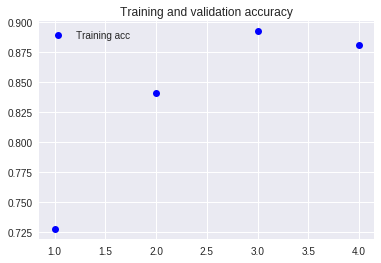

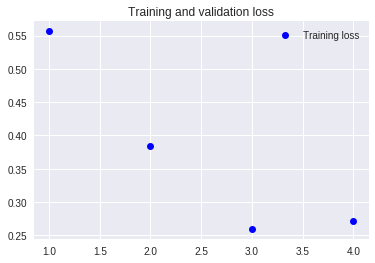

In [9]:
print(history.history)

acc = history.history['acc']
loss = history.history['loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Test

In [10]:
image_path = 'tumor_091.tif'
image_depth, image_width, tumor_mask, tissue_regions, slide_image_test = prepare_test_data(image_path, 
                                                                                           num_pixels=64, 
                                                                                           num_level=3)
create_second_level(image_path, 
                    input_level = 3, 
                    num_input_pixels = 64, 
                    output_level = 4, 
                    num_output_pixels = 64)

tumor_091.tif tumor_091_mask.tif


In [0]:
test_predicts = predict_test_data(image_path, 
                                  model, 
                                  tissue_regions, 
                                  slide_image_test, 
                                  tumor_mask, 
                                  image_depth, 
                                  image_width, 
                                  num_level_1 = 3, 
                                  num_level_2 = 4)

Text(0.5,1,'Predicted Heatmap')

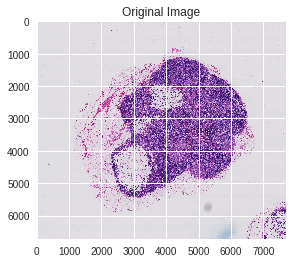

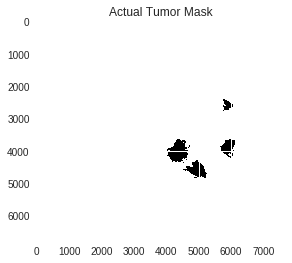

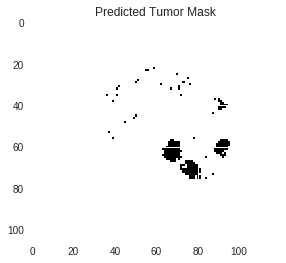

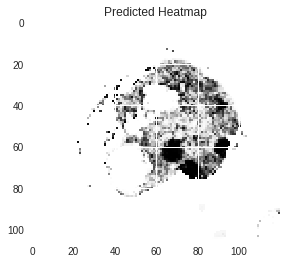

In [18]:
threshold = 0.95
all_image_paths = load_test_data_paths(image_path, 3)
probabilities, predictions = predict_mask(test_predicts, all_image_paths, image_depth, image_width, threshold)

fig1, ax1 = plt.subplots()
plt.imshow(slide_image_test)
ax1.set_title("Original Image")

fig2, ax2 = plt.subplots()
plt.imshow(tumor_mask)
ax2.set_title("Actual Tumor Mask")

fig3, ax3 = plt.subplots()
ax3.set_title("Predicted Tumor Mask")
plt.imshow(predictions)
    
fig4, ax4 = plt.subplots()
plt.imshow(probabilities)
ax4.set_title("Predicted Heatmap")

Precision: 0.7383831559207986
Recall: 0.8818187307198296
F1: 0.8037518073615273
AUC score 0.9318855913644686


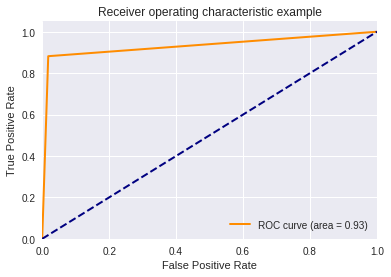

Confusion Matrix:
           Predicted 0  Predicted 1
Reality 0     12387993       227682
Reality 1        86122       642606
           Predicted 0  Predicted 1
Reality 0    92.832875     1.706198
Reality 1     0.645379     4.815547


In [20]:
evaluate_result(predictions, tumor_mask, tissue_regions)